In [1]:
## Begin with import statements from Kevin:
import numpy as np
#import scipy
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
#from scipy.special import erf
import math
#from scipy.optimize import least_squares
#from scipy.optimize import curve_fit


In [2]:
## Functions for Index Shift and Phase Shift from total timing difference:
# Each time index is 2.56us, we want total time/2.56us to give us the number of indices, ignoring remainder.
# Each phase shift depends on frequency... each 2pi occurs on timescale 1/f, want remainder to find phase shift

def Index_Shift_From_Time(time_array):
    return (time_array/(2.56e-6)).astype(int)
    
def Phase_Shift_From_Time(time_array,frequency):
    return time_array/(frequency**-1.0)#%(2*np.pi)

## Assume no lag, irrelevant for now

FS_Lag=0.0#typdist/SOL

FE_Lag=0.0#100.0/(0.85*SOL)


## DEFN the Gauss Fit function:
def Gauss(x,a,x0,sigma,k):
    return a*np.exp(-(x-x0)**2.0/(2.0*sigma**2.0))+k

In [3]:
# What Morgan did:
# phase = angle(complex) to get phase
# time = phase / 2pi / freq probably 

In [4]:
###### WILL's CODE, slightly modified for fewer iterations

In [5]:
## 2) Looping through 1000 of same jitter to test noise properties for Kalyani's new metric:
#stop
## This run is 50 jitters, 30 gains [hyperbolic distribution], 10000 iterations, input power 0, 4 int periods...
## Select fixed params that dictate run properties:
fman=727e6 #select freq
t_length=65536 # 4*16384
inputpower=1.0
iteration_space=np.arange(50)
jitter_space=np.hstack((np.array([0]),np.linspace(1e-12,4e-9,50)))
gain_space=(np.linspace(0.05,2.0,30)**2.0)
#jitter_space=[0.7E-9,1.7E-9]
#gain_space=[0.12,0.79]

# Now add lag
#SOL=299792458.0  #m/s
#typdist=np.sqrt((100.0**2.0)+(175.0**2.0))
#FS_Lag=typdist/SOL
### How big should we expect our front-end lags to be?
#FE_Lag=100.0/(0.85*SOL)
#print("A reasonable estimate for the FS_Lag is {:.4f}us".format(1e6*FS_Lag))
#print(" --> This corresponds to a free-space lag of {:.4f}us".format(1e6*typdist/SOL))
#print("A reasonable estimate for the Total_Lag=FS_Lag+FE_Lag is {:.4f}us".format(1e6*(FS_Lag+FE_Lag)))




## Define parameter arrays that we want to pull out for each jitter we test:
input_phase=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
## Unquantized (f) correlations:
nq_max_ind_auto=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(int)
nq_max_ind_cross=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(int)
nq_max_mag_auto_on=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)
nq_max_mag_auto_off=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)
nq_max_mag_cross_on=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)
nq_max_mag_cross_off=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)

signal=np.random.normal(0,inputpower,(len(iteration_space),t_length))+(1.0j*np.random.normal(0,inputpower,(len(iteration_space),t_length)))
noise_term=np.random.normal(0,inputpower,(len(iteration_space),t_length))+(1.0j*np.random.normal(0,inputpower,(len(iteration_space),t_length)))
noise_term_off=np.random.normal(0,inputpower,(len(iteration_space),t_length))+(1.0j*np.random.normal(0,inputpower,(len(iteration_space),t_length)))

for i,iteration in enumerate(iteration_space):
    for g,gain in enumerate(gain_space):
        f_signal=signal[i]
        f_signal_on=(gain*signal[i])+noise_term[i]
        f_signal_off=noise_term_off[i]
        for j,jitter in enumerate(jitter_space):
            print('Iteration:{}/{}, Gain:{}/{}, Jitter:{}/{}    '.format(i+1,len(iteration_space),g+1,len(gain_space),j+1,len(jitter_space)),end='\r')
            ## Draw a sample to populate the jitter array and construct index shift/phase:
            simtimearr=(np.ones(t_length)*(FS_Lag+FE_Lag))+np.random.normal(0,jitter,t_length)
            index_shift=int(np.nanmedian(Index_Shift_From_Time(simtimearr)))
            phase_rads=Phase_Shift_From_Time(simtimearr,fman)
            input_phase[j,g,i]=np.nanmean(phase_rads)
            phase_array=np.exp(-1.0j*phase_rads)
            #phase_array=np.exp(-1.0j*2.0*np.pi*phase_rads)
            ## create the f and q arrays:
            f_signal_on_ps=np.roll(phase_array*f_signal_on,index_shift)
            f_signal_off_ps=np.roll(phase_array*f_signal_off,index_shift)
            ## Select the scaling
            ## Perform correlations (unquantized):
            nq_auto_corr_on_ps=np.fft.ifft(np.fft.fft(f_signal_on_ps)*np.conjugate(np.fft.fft(f_signal_on_ps)))
            nq_auto_corr_off_ps=np.fft.ifft(np.fft.fft(f_signal_off_ps)*np.conjugate(np.fft.fft(f_signal_off_ps)))
            nq_cross_corr_on_ps=np.fft.ifft(np.fft.fft(f_signal_on_ps)*np.conjugate(np.fft.fft(f_signal)))
            nq_cross_corr_off_ps=np.fft.ifft(np.fft.fft(f_signal_off_ps)*np.conjugate(np.fft.fft(f_signal)))
            ## Populate loop auto variables (unquantized):
            nq_max_mag_auto_on[j,g,i]=nq_auto_corr_on_ps[0]
            nq_max_mag_auto_off[j,g,i]=nq_auto_corr_off_ps[0]
            nq_max_mag_cross_on[j,g,i]=nq_cross_corr_on_ps[0]
            nq_max_mag_cross_off[j,g,i]=nq_cross_corr_off_ps[0]                

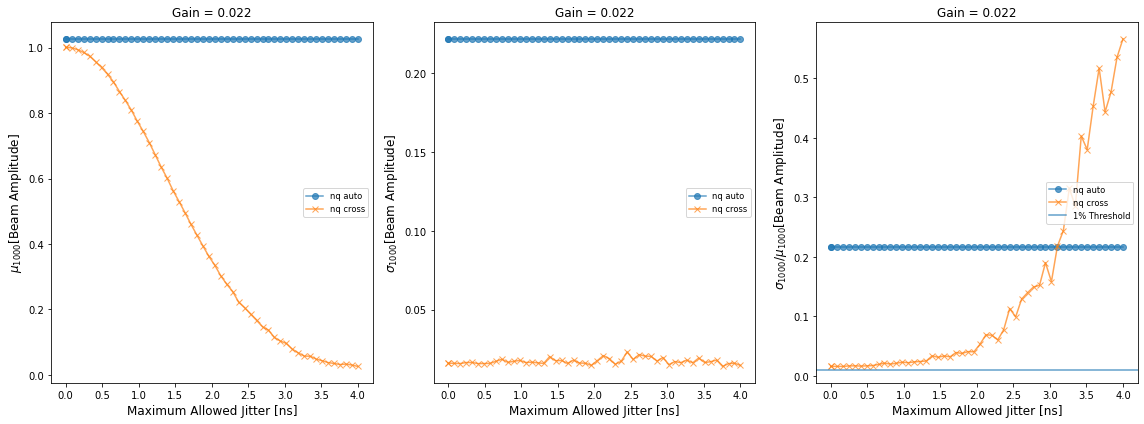

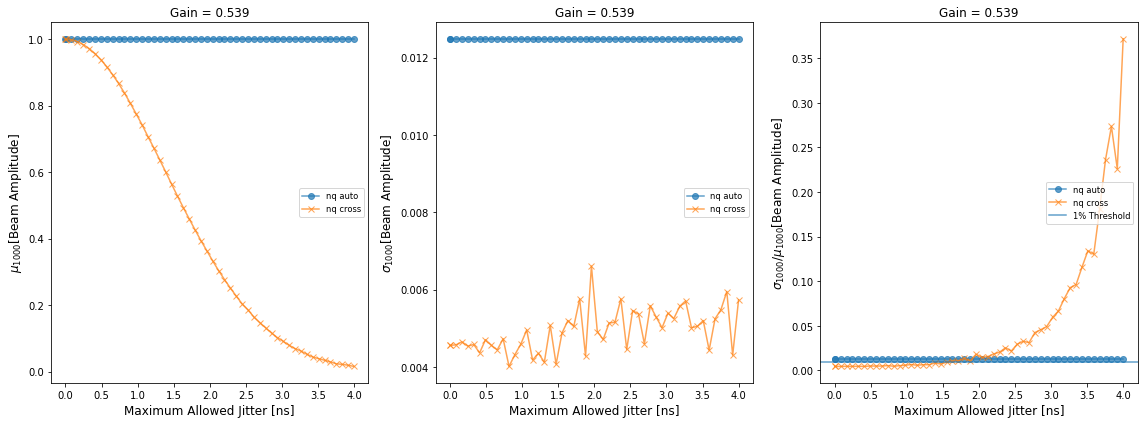

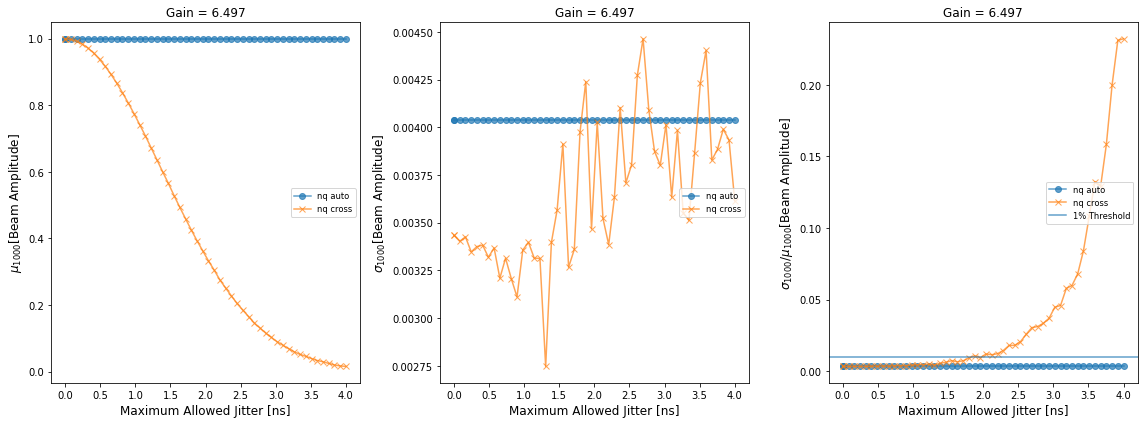

In [6]:
# Using Kalyani's recovered gain method:
for g in [5,12,23]:
    gain = gain_space[g]
    fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,6))
    nq_a_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**2.0))
    nq_c_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**1.0))
    
    for k,ax in enumerate([ax1]):
        ax.set_title("Gain = {:.3f}".format(gain_space[g]*gain_space[g]),fontsize='large')
        nq_x=nq_a_norm*np.nanmean((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)
        nq_y=nq_c_norm*np.nanmean(np.abs(nq_max_mag_cross_on[:,g,:]),axis=1)
        
        ax.plot(jitter_space*1e9,nq_x,'o-',alpha=0.7,label='nq auto')
        ax.plot(jitter_space*1e9,nq_y,'x-',alpha=0.7,label='nq cross')

        ax.set_ylabel("$\mu_{1000}$[Beam Amplitude]",fontsize='large')
        ax.set_xlabel('Maximum Allowed Jitter [ns]',fontsize='large')
        ax.legend(loc=5,fontsize='small')
    for k,ax in enumerate([ax2]):
        ax.set_title("Gain = {:.3f}".format(gain_space[g]*gain_space[g]),fontsize='large')
        nq_x=nq_a_norm*np.nanstd((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)
        nq_y=nq_c_norm*np.nanstd(np.abs(nq_max_mag_cross_on[:,g,:]),axis=1)
    
        ax.plot(jitter_space*1e9,nq_x,'o-',alpha=0.7,label='nq auto')
        ax.plot(jitter_space*1e9,nq_y,'x-',alpha=0.7,label='nq cross')

        ax.set_ylabel("$\sigma_{1000}$[Beam Amplitude]",fontsize='large')
        ax.set_xlabel('Maximum Allowed Jitter [ns]',fontsize='large')
        ax.legend(loc=5,fontsize='small')
    for k,ax in enumerate([ax3]):
        ax.set_title("Gain = {:.3f}".format(gain_space[g]*gain_space[g]),fontsize='large')
        nq_x=np.nanstd((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)/np.nanmean((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)
        nq_y=np.nanstd(np.abs(nq_max_mag_cross_on[:,g,:]),axis=1)/np.nanmean(np.abs(nq_max_mag_cross_on[:,g,:]),axis=1)

        ax.plot(jitter_space*1e9,nq_x,'o-',alpha=0.7,label='nq auto')
        ax.plot(jitter_space*1e9,nq_y,'x-',alpha=0.7,label='nq cross')
        ax.axhline(0.01,alpha=0.7,label='1% Threshold')
        ax.set_ylabel("$\sigma_{1000}$/$\mu_{1000}$[Beam Amplitude]",fontsize='large')
        ax.set_xlabel('Maximum Allowed Jitter [ns]',fontsize='large')
        ax.legend(loc=5,fontsize='small')
    tight_layout()

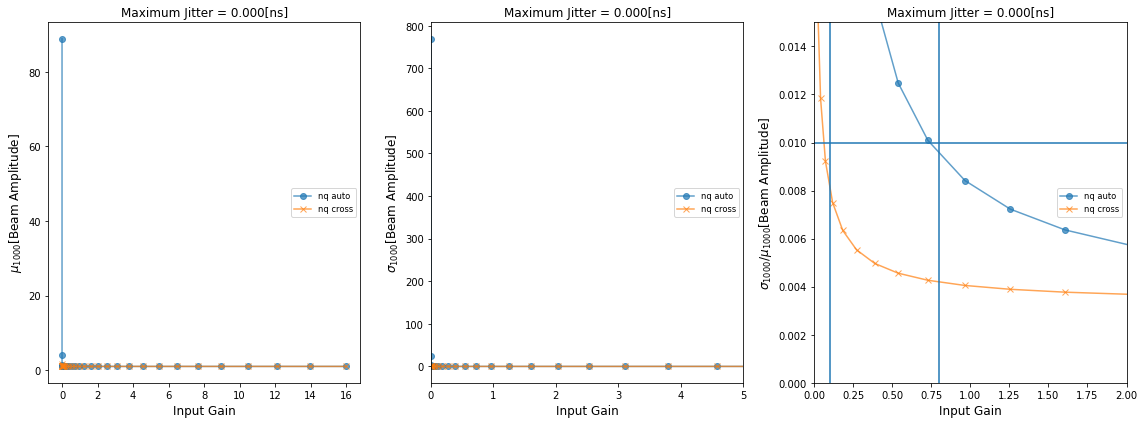

In [7]:
fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,6))
for j in [0]:
    ## AX 1 Mean
    nq_a_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[:]**2.0))
    nq_c_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[:]))
   
    nq_x=nq_a_norm*np.nanmean((np.abs(nq_max_mag_auto_on[j,:,:])-np.abs(nq_max_mag_auto_off[j,:,:])),axis=1)
    nq_y=nq_c_norm*np.nanmean(np.abs(nq_max_mag_cross_on[j,:,:]),axis=1)

    indlist=[0,100,200,300,400,500,600,700,800,999]
    #for bb,zz in enumerate(indlist[:-2]):
    #    nq_z=nq_a_norm*np.nanmean((np.abs(nq_max_mag_auto_on[j,:,indlist[bb]:indlist[bb+1]])-np.abs(nq_max_mag_auto_off[j,:,indlist[bb]:indlist[bb+1]])),axis=1)
    #    ax1.plot(gain_space,nq_z,'o-',alpha=0.7,label='nq auto {}'.format(indlist[bb]))
    ax1.plot(gain_space*gain_space,nq_x,'o-',alpha=0.7,label='nq auto')
    ax1.plot(gain_space*gain_space,nq_y,'x-',alpha=0.7,label='nq cross')
    ax1.set_ylabel("$\mu_{1000}$[Beam Amplitude]",fontsize='large')
    ## AX 2 STD
    nq_x=nq_a_norm*np.nanstd((np.abs(nq_max_mag_auto_on[j,:,:])-np.abs(nq_max_mag_auto_off[j,:,:])),axis=1)
    nq_y=nq_c_norm*np.nanstd(np.abs(nq_max_mag_cross_on[j,:,:]),axis=1)
   
    ax2.plot(gain_space*gain_space,nq_x,'o-',alpha=0.7,label='nq auto')
    ax2.plot(gain_space*gain_space,nq_y,'x-',alpha=0.7,label='nq cross')

    ax2.set_xlim(0,5)
    #ax2.set_ylim(0.005,0.015)
    ax2.set_ylabel("$\sigma_{1000}$[Beam Amplitude]",fontsize='large')
    ## AX 3 STD/Mean
    nq_x=np.nanstd((np.abs(nq_max_mag_auto_on[j,:,:])-np.abs(nq_max_mag_auto_off[j,:,:])),axis=1)/np.nanmean((np.abs(nq_max_mag_auto_on[j,:,:])-np.abs(nq_max_mag_auto_off[j,:,:])),axis=1)
    nq_y=np.nanstd(np.abs(nq_max_mag_cross_on[j,:,:]),axis=1)/np.nanmean(np.abs(nq_max_mag_cross_on[j,:,:]),axis=1)
    
    ax3.plot(gain_space*gain_space,nq_x,'o-',alpha=0.7,label='nq auto')
    ax3.plot(gain_space*gain_space,nq_y,'x-',alpha=0.7,label='nq cross')

    ax3.axhline(0.01)
    ax3.axvline(0.1)
    ax3.axvline(0.8)
    ax3.set_xlim(0,2)
    ax3.set_ylim(0.000,0.015)
    ax3.set_ylabel("$\sigma_{1000}$/$\mu_{1000}$[Beam Amplitude]",fontsize='large')
    for ax in [ax1,ax2,ax3]:
        ax.set_title("Maximum Jitter = {:.3f}[ns]".format(1e9*jitter_space[j]),fontsize='large')
        ax.set_xlabel('Input Gain',fontsize='large')
        ax.legend(loc=5,fontsize='small')      
tight_layout()

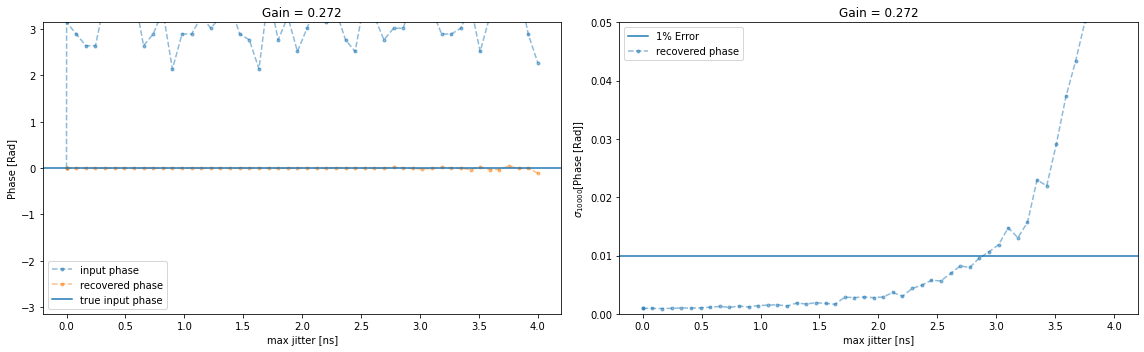

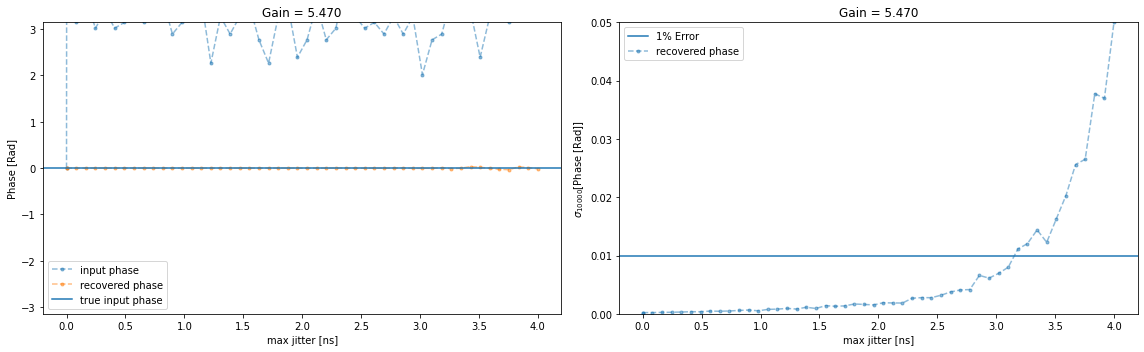

In [8]:
for g in [10,22]:
    gain = gain_space[g]
    fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,5))
    ax1.plot(jitter_space*1e9,np.nanmean(input_phase[:,g,:]%(2*np.pi),axis=1),'.--',alpha=0.5,label='input phase')
    ax1.plot(jitter_space*1e9,np.nanmean(-np.angle(nq_max_mag_cross_on[:,g,:]),axis=1),'.--',alpha=0.5,label='recovered phase')
    ax1.set_ylim(-np.pi,np.pi)
    ax2.set_ylim(0.0,0.05)
    ax1.axhline(input_phase[0,0,0]%(2*np.pi),label='true input phase')    
    ax2.axhline(0.01,label='1% Error')    
    ax2.plot(jitter_space*1e9,np.nanstd(-np.angle(nq_max_mag_cross_on[:,g,:]),axis=1)/(2.0*np.pi),'.--',alpha=0.5,label='recovered phase')
    for ax in [ax1,ax2]:
        ax.set_title("Gain = {:.3f}".format(gain*gain))
        ax.set_xlabel('max jitter [ns]')
        ax.legend()

    ax1.set_ylabel('Phase [Rad]')
    ax2.set_ylabel('$\sigma_{10000}$[Phase [Rad]]')

    tight_layout()
    

In [9]:
for g in [5,12,23]:
    gain = gain_space[g]
    for j in [10,21]:
        jit = jitter_space[j]
        nq_a_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain**2.0))
        nq_c_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain))
    
        nq_x=np.nanstd((np.abs(nq_max_mag_auto_on[j,g,:])-np.abs(nq_max_mag_auto_off[j,g,:])))/np.nanmean((np.abs(nq_max_mag_auto_on[j,g,:])-np.abs(nq_max_mag_auto_off[j,g,:])))
        nq_y=np.nanstd(np.abs(nq_max_mag_cross_on[j,g,:]))/np.nanmean(np.abs(nq_max_mag_cross_on[j,g,:]))

        print('gain ', gain, 'jitter ', jit, ', auto, cross gain %: ',100*nq_x, 100*nq_y)

gain  0.14915576694411412 jitter  7.355102040816326e-10 , auto, cross gain %:  21.582349964119427 2.145812108062357
gain  0.14915576694411412 jitter  1.6332448979591837e-09 , auto, cross gain %:  21.582349964119523 3.204888021013848
gain  0.7342717003567182 jitter  7.355102040816326e-10 , auto, cross gain %:  1.247724438012011 0.5456735791746335
gain  0.7342717003567182 jitter  1.6332448979591837e-09 , auto, cross gain %:  1.2477244380120107 1.054166776158772
gain  2.5489774078478002 jitter  7.355102040816326e-10 , auto, cross gain %:  0.4042383456053537 0.38252157916739293
gain  2.5489774078478002 jitter  1.6332448979591837e-09 , auto, cross gain %:  0.40423834560535216 0.6617941165516947


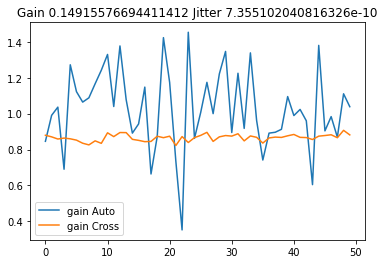

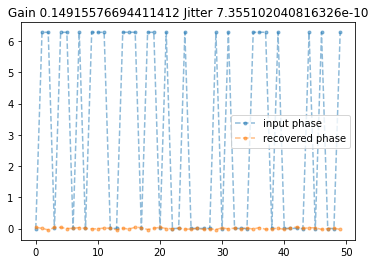

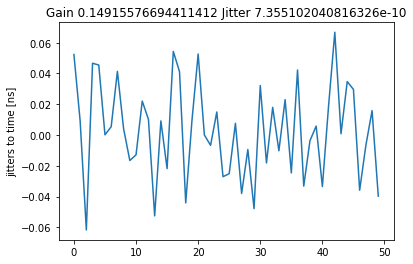

0.0311858046687731


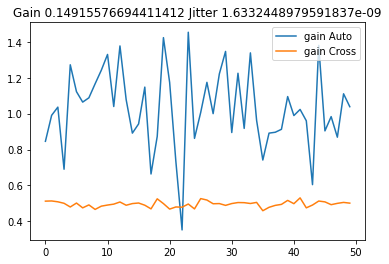

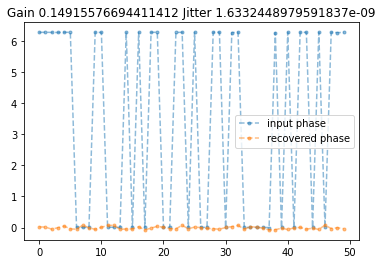

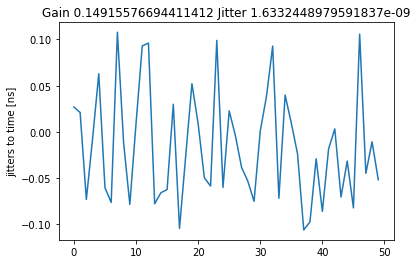

0.05973265847196557


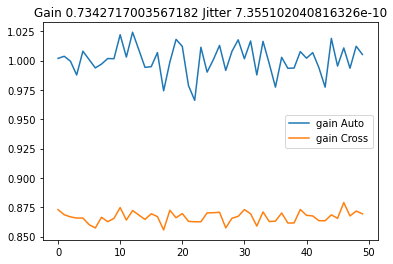

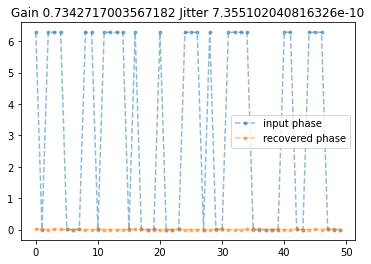

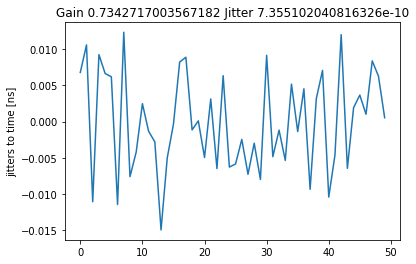

0.006792825329613225


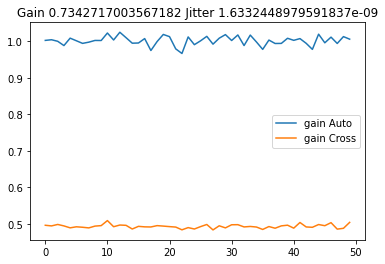

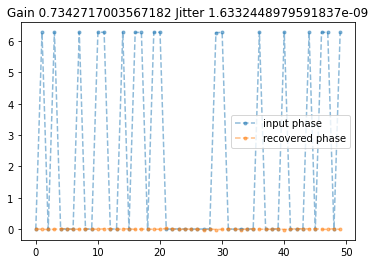

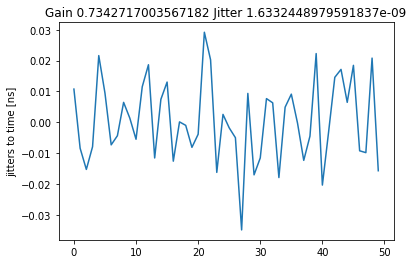

0.013358991202169285


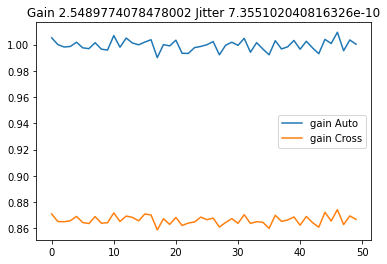

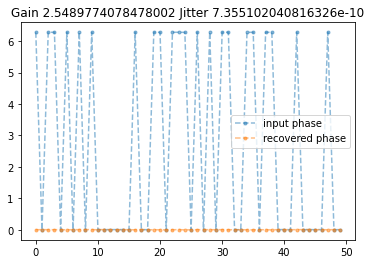

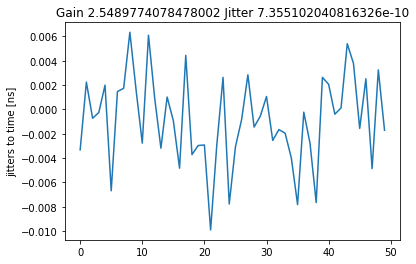

0.0036409475450631997


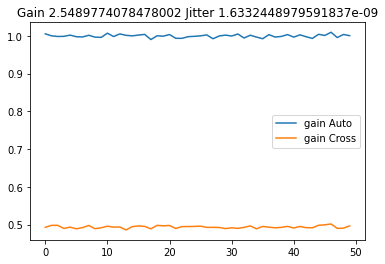

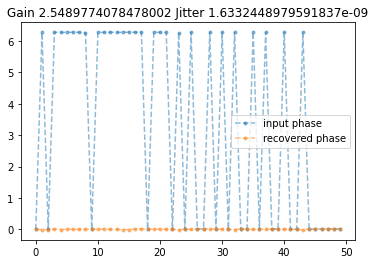

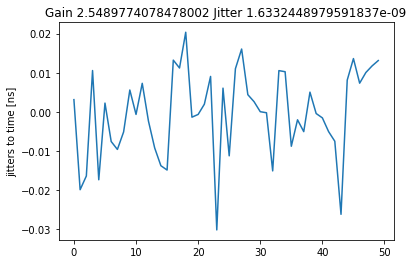

0.011131461765769101


In [11]:
## Let's plot what happens over the iterations:

for g in [5,12,23]:
    gain = gain_space[g]
    for j in [10,21]:
        jit = jitter_space[j]
        nq_a_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain**2.0))
        nq_c_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain))
    
        nq_aa=nq_a_norm*(np.abs(nq_max_mag_auto_on[j,g,:])-np.abs(nq_max_mag_auto_off[j,g,:]))
        nq_ca=nq_c_norm*(np.abs(nq_max_mag_cross_on[j,g,:]))

        plt.plot(nq_aa, label='gain Auto')
        plt.plot(nq_ca, label='gain Cross')
        plt.title('Gain '+str(gain)+' Jitter '+str(jit))
        plt.legend()
        plt.show()

        ip = input_phase[j,g,:]%(2*np.pi)
        rp = -np.angle(nq_max_mag_cross_on[j,g,:])

        plt.plot(ip,'.--',alpha=0.5,label='input phase')
        plt.plot(rp,'.--',alpha=0.5,label='recovered phase')
        plt.title('Gain '+str(gain)+' Jitter '+str(jit))
        plt.legend()
        plt.show()

        times = 1E9* rp / 2*np.pi / fman
        plt.plot(times)
        plt.ylabel('jitters to time [ns]')
        plt.title('Gain '+str(gain)+' Jitter '+str(jit))
        plt.show()
        print(np.std(times))

In [ ]:
###### OLD INVESTIGATION, JUST ONE GAIN, ONE JITTER, ONE ITERATION

# For my first try, skip all the iterations and just compute the gain and phase with one jitter value, once
f_signal=signal[i]
f_signal_on=(gain*signal[i])+noise_term[i]
f_signal_off=noise_term_off[i]
        
simtimearr=(np.ones(t_length)*(FS_Lag+FE_Lag))+np.random.normal(0,jitter,t_length)
index_shift=int(np.nanmedian(Index_Shift_From_Time(simtimearr)))
phase_rads=Phase_Shift_From_Time(simtimearr,fman) # jitter, time
phase_array=np.exp(-1.0j*phase_rads) # jitter, time 
# need a 2pi in phase_array to force phase rads and phase array to agree when plotting angle(phase array)
# removing for now to reproduce Will's stuff 

input_phase[j,g,i]=np.nanmean(phase_rads) # mean across time

plt.plot(simtimearr)
plt.ylabel('time jitter')
plt.show()

print(phase_rads.shape)
plt.plot(phase_rads,label='phase shift')
plt.plot(np.angle(phase_array),label='phase array (rad)')
plt.ylabel('phase shift (rad)')
plt.legend()
plt.show()

print('input phase: ', input_phase[j,g,i])
print('size of phase array:', phase_array.shape) # length time
     
# No jitter signals, for comparison:
nj_cross_on = np.fft.ifft(np.fft.fft(f_signal_on)*np.conjugate(np.fft.fft(f_signal)))

plt.plot(nj_cross_on.real)
plt.plot(nj_cross_on.imag)

print(nj_cross_on.real[0],nj_cross_on.imag[0],np.angle(nj_cross_on[0]))

nj_auto_on = np.abs(np.fft.ifft(np.fft.fft(f_signal_on)*np.conjugate(np.fft.fft(f_signal_on))))
nj_auto_off = np.abs(np.fft.ifft(np.fft.fft(f_signal_off)*np.conjugate(np.fft.fft(f_signal_off))))

print(nj_auto_on[0],nj_auto_off[0],nj_auto_on[0]/nj_auto_off[0])

## create the f and q arrays:
f_signal_on_ps=np.roll(phase_array*f_signal_on,index_shift) # jitter, time
f_signal_off_ps=np.roll(phase_array*f_signal_off,index_shift)
            
## Perform correlations (unquantized):
nq_auto_corr_on_ps=np.abs(np.fft.ifft(np.fft.fft(f_signal_on_ps)*np.conjugate(np.fft.fft(f_signal_on_ps))))
nq_auto_corr_off_ps=np.abs(np.fft.ifft(np.fft.fft(f_signal_off_ps)*np.conjugate(np.fft.fft(f_signal_off_ps))))
nq_cross_corr_on_ps=np.fft.ifft(np.fft.fft(f_signal_on_ps)*np.conjugate(np.fft.fft(f_signal)))
nq_cross_corr_off_ps=np.fft.ifft(np.fft.fft(f_signal_off_ps)*np.conjugate(np.fft.fft(f_signal)))
    

plt.plot(f_signal.real)
plt.plot(f_signal.imag)
plt.ylabel('f signal')
plt.show()

plt.plot(f_signal_on.real)
plt.plot(f_signal_on.imag)
plt.plot(f_signal_off.real)
plt.plot(f_signal_off.imag)
plt.ylabel('f signal on, off after gain')
plt.show()

print(index_shift)
plt.plot(f_signal_on_ps.real)
plt.plot(f_signal_on_ps.imag)
plt.plot(f_signal_off_ps.real)
plt.plot(f_signal_off_ps.imag)
plt.ylabel('f signal on, off after gain, rolling')
plt.show()

plt.plot(nq_auto_corr_on_ps.real,label='auto,real')
plt.plot(nq_auto_corr_on_ps.imag,label='auto,imag')
plt.plot(nq_cross_corr_on_ps.real,label='cross,real')
plt.plot(nq_cross_corr_on_ps.imag,label='cross,imag')
plt.legend()
plt.ylabel('f signal on, off after correlation')
plt.show()

plt.plot(nq_auto_corr_on_ps.real,label='auto,real')
plt.plot(nq_auto_corr_on_ps.imag,label='auto,imag')
plt.plot(nq_cross_corr_on_ps.real,label='cross,real')
plt.plot(nq_cross_corr_on_ps.imag,label='cross,imag')
plt.legend()
plt.ylabel('f signal on, off after correlation')
plt.xlim(0,2)
plt.show()

#plt.plot(nq_auto_corr_on_ps.real,label='auto,real')
#plt.plot(nq_auto_corr_on_ps.imag,label='auto,imag')
plt.plot(nq_cross_corr_on_ps.real,label='cross,real')
plt.plot(nq_cross_corr_on_ps.imag,label='cross,imag')
plt.legend()
plt.ylabel('f signal on, off after correlation')
plt.xlim(0,2)
plt.show()

# all power in 0 lag, define that as max instead of solving for it

nq_max_ind_auto=0
nq_max_mag_auto_on=nq_auto_corr_on_ps[0]
nq_max_mag_auto_off=nq_auto_corr_off_ps[0]
nq_max_ind_cross=0
nq_max_mag_cross_on=nq_cross_corr_on_ps[0]
nq_max_mag_cross_off=nq_cross_corr_off_ps[0] 

# Compare phases
print('input jitter phase: ', input_phase[j,g,i])
print('actual input phase: ',np.angle(nj_cross_on[0]))
print('output phase:', np.angle(nq_max_mag_cross_on))

# Compare gains

nq_a_norm=1.0/(2*(t_length))
nq_c_norm=1.0/(2*(t_length))

ig = gain
og = np.sqrt((nq_max_mag_auto_on-nq_max_mag_auto_off)/nq_max_mag_auto_off)

print('input gain: ', ig)
print('output gain (auto): ',og)
print('error [%]: ', 100*(ig - og)/ig )

print('output gain (cross): ',nq_c_norm*np.abs(nq_max_mag_cross_on))
print('error [%]: ', 100*(ig - nq_c_norm*np.abs(nq_max_mag_cross_on))/ig )